# CS 39AA - A Perceptron from Scratch

In this notebook we'll look get a good look at a simple neural network, a single layer perceptron, and at how this is directly related to logistic regression. We'll also use gradient descent to find the optimal parameter values for our model, based on the training data that we have. 

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgeinitz/cs39aa_notebooks/blob/main/nb_E_perceptron_from_scratch.ipynb)


## I. Logistic Regression

### 1: Generate data
We'll first import the necessary Python modules and then generate synthetic data with appropriate size/dimensions. 

Let's now plot the generated data to see x and y. Note that the y outcomes/labels belong to one of two classes. The positive cases are shown in blue while negative cases are in red.

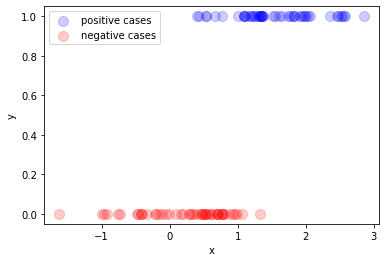

In [190]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

N = 100 # total number of observations
D_in = 1 # input dimension (i.e. dimension of a single observation's x vector)
D_out = 1 # output dimension (i.e. y), so just 1 for this example
random.seed(1)
np.random.RandomState(1)

# Create random input data and derive the 'true' labels/output
x = np.random.randn(N, D_in) + 1 
def true_y(x_in, n_obs):
    def addNoise(x):
        if abs(x-1) < 1:
            return 0.1
        elif abs(x-1) < 0.1:
            return 0.25
        else:
            return 0.01

    return np.apply_along_axis(lambda x: [int(x < 1) if random.random() < addNoise(x) else int(x > 1)], 1, x_in)
    
y = true_y(x, N).flatten()

plt.scatter(x[y == 1,0], y[y == 1], c='blue', s=100, alpha=0.2)
plt.scatter(x[y == 0,0], y[y == 0], c='red', s=100, alpha=0.2)
plt.xlabel("x")
plt.ylabel("y")
plt.legend(('positive cases', 'negative cases'))
plt.show()

Let's quickly peek at the x and y data objects (i.e. numpy arrays) to see what their size, shape, and rank look like.

In [191]:
print(f"y.size: {y.size}")
print(f"y.shape: {y.shape}")
print(f"y.ndim: {y.ndim}")

print(f"x.size: {x.size}")
print(f"x.shape: {x.shape}")
print(f"x.ndim: {x.ndim}")

y.size: 100
y.shape: (100,)
y.ndim: 1
x.size: 100
x.shape: (100, 1)
x.ndim: 2


### 2. Fit Logistic Regression Model

Let's find estimates for $\beta_0$ and $\beta_1$ using a logistic regression model in order to predict/estimate the probability that y is in the positive or negative class for any given x. In traditional statistics there is a large class of models known as [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model), which allow for a linear regression to be used to predict some transformation of the target variable. With logistic regression we transform the target variable, $Y$ (a binary 0 or 1) by looking at the log-odds of the expected value of $y_i$. If we let $\mu_i = E(y_i)$ be the probability that $y_i$ equals 1, then we that the log-odds are as follows (note that the log-odds are formally known as the [logit](https://en.wikipedia.org/wiki/Logit) function):

* $\mathrm{logit}(\mu_i) = ln\Big( \frac{\mu_i}{1 - \mu_i} \Big)= \beta_0 + \beta_1*x_i$

Notice that the right side of the formula is in the familiar linear regression format of $\beta$ coefficients and their corresponding $x$ covariates. 

When it comes time to make a prediction for a new $y_i$, we'll then use the inverse of the logit function, which happens to be the logistic, or sigmoid, function:

* $\hat{\mu}_i = \mathrm{logit}^{-1}\Big( \mathrm{logit}(\mu_i) \Big) = \mathrm{logit}^{-1}(\beta_0 + \beta_1*x_i) = \frac{1}{1 + e^{-(\beta_0 + \beta_1*x_i)}}$

In [192]:
from sklearn.linear_model import LogisticRegression
logreg_model = LogisticRegression(random_state=42, max_iter=100, tol=1e-3, solver='liblinear')
logreg_model.fit(x, y)

print(f" beta0 = {logreg_model.intercept_[0]:.4f}")
print(f" beta1 = {logreg_model.coef_[0][0]:.4f}")
y_pred = logreg_model.predict_proba(x)
lr_loss = 1/N * np.square(y - y_pred[:,1]).sum()
print(f" loss (mse) = {lr_loss:.4f}")

 beta0 = -2.1686
 beta1 = 2.5520
 loss (mse) = 0.0960


To find those estimates scikit learn's LogisticRegression model solved an optimization problem that we are familiar with, which was to minimize the loss function. Recall that the mean-squared error loss function looks like this: 

* $\mathrm{Loss}_{MSE} = \frac{1}{N} \sum_i^N (y_i - \hat{y}_i)^2$


If we state $\hat{y}_i$ in terms of our model parameters then, as seen above, we have the following: 

* $ \mathrm{Loss}_{MSE} = \frac{1}{N} \sum_i^N \Big( y_i - (1 + e^{-(\beta_0 + \beta_1*x_i)})^{-1} \Big)^2$

By writing the loss function as a function of our model parameters, we can then plot the surface of the loss with $\beta_0$ and $\beta_1$ on the x and y axes, respectively. We can then see where the optimal values might be. Remember that in practice, when we have hundreds, thousands, or more, model parameters, that it is impossible to plot the loss surface in this way. 

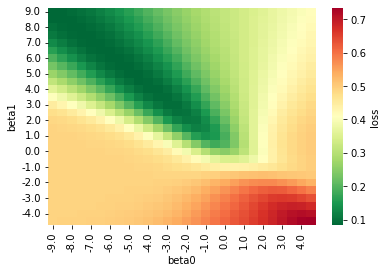

In [193]:
#b1s = np.arange(6, -4.1, -0.5)
#b0s = np.arange(-6, 4.1, 0.5)
b1s = np.arange(9, -5, -0.5)
b0s = np.arange(-9, 5, 0.5)
surf = np.array( [[1/N * np.square(y - 1 / (1 + np.exp(-1 * (b1s[i]*x[:,0] + b0s[j])))).sum() for j in range(len(b0s))] for i in range(len(b1s))] )
df = pd.DataFrame(surf, columns=b0s, index=b1s)
p1 = sns.heatmap(df, cbar_kws={'label': 'loss'}, cmap="RdYlGn_r")
plt.xlabel("beta0")
plt.ylabel("beta1")
plt.show()

Notice above that there does not appear to be one unique pair of values for $\beta_0$, $\beta_1$ that will yield a minimum loss value. That is to say, there is no single point on the surface we plotted above where the loss has an obvivous global minimum. Instead, it looks as if the loss continues to decrease as $\beta_0$ gets smaller and $\beta_1$ gets larger. 

What would happen if we chose to use another loss function? Would the log-loss (aka binary cross-entropy) function look much different? The log-loss, or binary cross-entropy function is defined as follows. 

* $\mathrm{Loss}_{BCE} = - \sum_i^N \Big( y_i * \mathrm{ln}(\hat{y}_i) + (1 - y_i)*\mathrm{ln}(1-\hat{y}_i) \Big)$

This is a different looking function altogether from the MSE. We would expect, however, that the surface would be similar though so that we would ultimately find similar parameter values. Let's plot this now to see. (Note that in practice the log-loss is the loss function typically used for logistic regression models.)

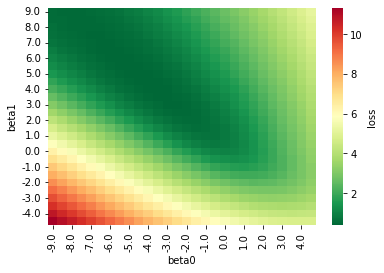

In [194]:
#b1s = np.arange(9, -4.1, -0.5)
#b0s = np.arange(-9, 4.1, 0.5)
b1s = np.arange(9, -5, -0.5)
b0s = np.arange(-9, 5, 0.5)
surf = np.array( [[ -((y * np.log2(1 / (1 + np.exp(-1 * (b1s[i]*x[:,0] + b0s[j])))) + (1-y) * np.log2(1 - 1 / (1 + np.exp(-1 * (b1s[i]*x[:,0] + b0s[j])))))/100).sum() for j in range(len(b0s))] for i in range(len(b1s))] )
df = pd.DataFrame(surf, columns=b0s, index=b1s)
p1 = sns.heatmap(df, cbar_kws={'label': 'loss'}, cmap="RdYlGn_r")
plt.xlabel("beta0")
plt.ylabel("beta1")
plt.show()

Although the two surfaces are noticeably distinct from one another, they do appear to agree on what values of the parameters will minimize the loss. It appears that in both cases the loss will be minimized when $\beta_0$ is a small value (far to the left on the graph) and $\beta_1$ is a large value (up high on the graph).

### 3: Predict y for a Newly Observed x

Let's see now what the model looks like using the parameter estimates found above (i.e. $\beta_0 = -2.17$, $\beta_1 = 2.55$). Next let's assume we are given a new observation to make a prediction for, and for this new observation we have $x = 1.5$. We can then predict whether it is a positive or negative case by evaluating the logistic function at $x = 1.2$. This yields $\hat{y} \approx 0.7$ (see below). 

Since $0.5$ is the typical cutoff value for predicting a positive (vs negative label), and $0.7 > 0.5$, we would likely predict this to be a positive case. 

__TIP:__ Try changing the values of the model parameters $\beta_0$ and $\beta_1$ below. Using the plots of the loss surfaces above, try choosing values of the model parameters look like they will yield an even lower point on the surface (i.e. smaller value of loss function). What happens to the plot below when doing so? 

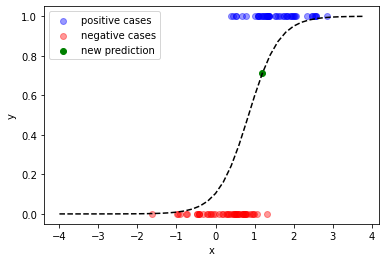

0.7109495026250039

In [195]:
b0 = -2.16
b1 = 2.55

plt.scatter(x[y == 1,0], y[y == 1], c='blue', alpha=0.4)
plt.scatter(x[y == 0,0], y[y == 0], c='red', alpha=0.4)
plt.xlabel("x")
plt.ylabel("y")

x_new = 1.2
y_hat_new = 1 / (1 + np.exp(-b0 - b1*x_new))
plt.scatter(x_new, y_hat_new, color="green")
plt.legend(('positive cases', 'negative cases', 'new prediction'), loc='upper left')

xes = np.arange(-4, 4, 0.2)
plt.plot(xes, 1/(1 + np.exp(-b0 - b1*xes)), 'k--')

plt.show()
y_hat_new


## II. A Simple Perceptron


### 1. Simple Perceptron w/ NumPy

Using the same $x$ and $y$ data as before we will now see how a simple perceptron network with a sigmoid activiation function is equivalent to the logistic regression model above. Rather than $\beta_0$, $\beta_1$, the parameters to be estimated are generally referred to as the weight and bias terms ($w$ and $b$, respectively). For this simple case they differ only in name though, such that:
* $\beta_0 = b$
* $\beta_1 = w$

To begin we will manually train the perceptron using numpy and gradient descent to minimize the loss. This will involve taking the derivatives of $w$ and $b$ (using the chain rule) to calculate the gradients in an interative process. 


iteration 0: loss = 0.1888, w = 0.4967, b = -0.1383
iteration 50: loss = 0.1251, w = 1.3366, b = -1.0191
iteration 100: loss = 0.1100, w = 1.7513, b = -1.4676
iteration 150: loss = 0.1030, w = 2.0403, b = -1.7678
iteration 200: loss = 0.0989, w = 2.2638, b = -1.9963
 w = 2.4466
 b = -2.1816


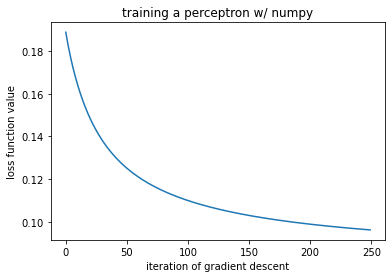

In [196]:
# Randomly initialize parameters to be estimated
np.random.seed(42)
w = np.random.randn(1)
b = np.random.randn(1)

# learning rate parameter
learning_rate = 5e-1

# keep track of loss to see how the optimization performs
loss = []

# Begin gradient descent using all of the observations in each iteration
for i in range(250):

    # Forward pass: compute predicted y
    lin_pred = w[0] * x[:,0] + b[0]
    y_pred = 1 / (1 + np.exp(-1 * lin_pred)) 

    # Compute and store loss, and print occassionally
    loss.append(1/N * np.square(y - y_pred).sum())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss[i]:.4f}, w = {w[0]:.4f}, b = {b[0]:.4f}")

    # Backprop to compute gradients of w and b with respect to log loss
    dloss_dypred = -2.0 / N * (y - y_pred)
    dypred_dlinpred = np.exp(-lin_pred) * (1 / np.square(1 + np.exp(-1 * lin_pred)))
    dlinpred_dw = x[:,0]
    dlinpred_db = 1

    # Backprop to compute gradients of w and b with respect to loss and being careful not to sum up intermediate parts
    #grad_w = -2 / N * (y - 1 / (1 + np.exp(-1 * lin_pred))) * (1 / np.square(1 + np.exp(-1 * lin_pred))) * x[:,0] * np.exp(-lin_pred) 
    #grad_b = -2 / N * (y - 1 / (1 + np.exp(-1 * lin_pred))) * (1 / np.square(1 + np.exp(-1 * lin_pred))) * np.exp(-lin_pred) 

    # Calculate gradients and update weight and bias parameters 
    grad_w = (dloss_dypred * dypred_dlinpred * dlinpred_dw).sum()
    grad_b = (dloss_dypred * dypred_dlinpred * dlinpred_db).sum()
    w -= learning_rate * grad_w
    b -= learning_rate * grad_b

print(f" w = {w.item():.4f}")
print(f" b = {b.item():.4f}")

plt.plot(range(0,len(loss)), loss)
plt.title("training a perceptron w/ numpy")
plt.xlabel("iteration of gradient descent")
plt.ylabel("loss function value")
plt.show()

### 2. Simple Perceptron w/ PyTorch

Now we will train a basic perceptron using PyTorch to take advantage of its ability to perform automatic differentation. This allows us to avoid calculating derivatives manually. 

In [197]:
import torch

# Randomly initialize weights and other data
torch.manual_seed(42)
w = torch.randn(1, requires_grad=True)
b = torch.randn(1, requires_grad=True)
x_tensor = torch.tensor(x)
y_tensor = torch.tensor(y)
learning_rate = 5e-1
losses = []

# Carry out gradient descent 
for i in range(250):

    # Forward pass: compute predicted y
    lin_pred = w * x_tensor + b
    y_pred = lin_pred.flatten().sigmoid()

    # Compute and store loss, and print occassionally 
    loss = 1/N * (y_tensor - y_pred).pow(2).sum()
    losses.append(loss.item())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss.item():.4f}, w = {w[0]:.4f}, b = {b[0]:.4f}")

    # Backprop using PyTorch's automatic differentiation 
    loss.backward()

    # Update parameters but don't include these calculations as part of underlying computational graph
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    # Reset gradients for next iteration 
    w.grad.zero_()
    b.grad.zero_()

print(f" w = {w.item():.4f}")
print(f" b = {b.item():.4f}")

iteration 0: loss = 0.2144, w = 0.3367, b = 0.1288
iteration 50: loss = 0.1289, w = 1.2587, b = -0.9308
iteration 100: loss = 0.1114, w = 1.7017, b = -1.4152
iteration 150: loss = 0.1037, w = 2.0036, b = -1.7301
iteration 200: loss = 0.0994, w = 2.2345, b = -1.9665
 w = 2.4223
 b = -2.1570


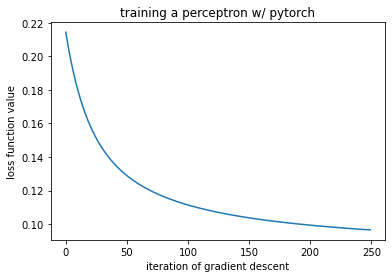

In [198]:
plt.plot(range(0,len(losses)), losses)
plt.title("training a perceptron w/ pytorch")
plt.xlabel("iteration of gradient descent")
plt.ylabel("loss function value")
plt.show()

## III. Using More PyTorch Capabilities

### 1: Defining a Perceptron w/ PyTorch

Now we will train a basic perceptron using PyTorch to define the model architecture itself, while continuing to take advantage of its automatic differentation. 

In [199]:
# Randomly initialize weights and other data
torch.manual_seed(42)
#del w #= torch.randn(1, requires_grad=True).reshape(1,1)
#del b #b = torch.randn(1, requires_grad=True).reshape(1,1)
x_tensor = torch.tensor(x).float()
y_tensor = torch.tensor(y).float().reshape(N, D_out)

# Define and declare a pytorch perceptron using sigmoid activation function 
model = torch.nn.Sequential(
    torch.nn.Linear(1, 1),
    torch.nn.Sigmoid()
)

# Define loss function to be used 
loss_fn = torch.nn.MSELoss()

learning_rate = 5e-1
losses = []

# Carry out gradient descent 
for i in range(250):

    # Forward pass: compute predicted y
    y_pred = model.forward(x_tensor)
    
    # Compute and store loss, and print occassionally 
    loss = loss_fn(y_pred, y_tensor)
    losses.append(loss.item())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss.item():.4f}")

    model.zero_grad()

    # Backprop using PyTorch's automatic differentiation 
    loss.backward()

    # Update parameters but don't include these calculations as part of underlying computational graph
    with torch.no_grad():
        for param in model.parameters():
            param.data -= learning_rate * param.grad

print("parameter values after training:")
for i, param in enumerate(model.parameters()):
    print(f"  param {i} est = {param.item():.4f}")

iteration 0: loss = 0.2789
iteration 50: loss = 0.1332
iteration 100: loss = 0.1129
iteration 150: loss = 0.1045
iteration 200: loss = 0.0998
parameter values after training:
  param 0 est = 2.3991
  param 1 est = -2.1336


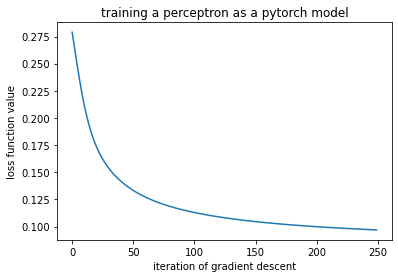

In [200]:
plt.plot(range(0,len(losses)), losses)
plt.title("training a perceptron as a pytorch model")
plt.xlabel("iteration of gradient descent")
plt.ylabel("loss function value")
plt.show()

### 2. PyTorch Optimizer

Now we will train a basic perceptron using PyTorch to define the model itself and also to carry out the Adam optimization method (a extension of gradient descent that adaptively estimates gradients to be able to find minima more quickly). 

iteration 0: loss = 0.7463
iteration 50: loss = 0.3700
iteration 100: loss = 0.3052
iteration 150: loss = 0.2862
iteration 200: loss = 0.2786
w and b estimates:
    3.9430
    -3.4496


[Text(0.5, 0, 'optimization iteration'), Text(0, 0.5, 'parameter: b')]

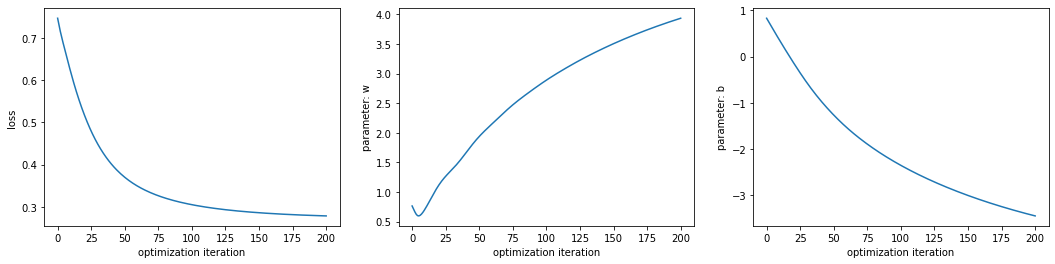

In [201]:
# Randomly initialize weights and other data
torch.manual_seed(42)
x_tensor = torch.tensor(x).float()
y_tensor = torch.tensor(y).float().reshape(N, D_out)

# Declare a perceptron instance
model = torch.nn.Sequential(
    torch.nn.Linear(D_in, D_out),
    torch.nn.Sigmoid()
)

# Define loss function to be used 
#loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.BCELoss()
learning_rate = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
params = []

# Carry out gradient descent 
for i in range(200 + 1):

    params.append(tuple([param.item() for param in model.parameters()]))

    # Forward pass: compute predicted y
    y_pred = model.forward(x_tensor)
    
    # Compute and store loss, and print occassionally 
    loss = loss_fn(y_pred, y_tensor)
    losses.append(loss.item())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss.item():.4f}")

    # Zero all gradients before backward pass
    optimizer.zero_grad()

    # Backprop then call optimizer step to update all (relevant) model parameters for us
    loss.backward()
    optimizer.step()

print("w and b estimates:")
for param in model.parameters():
    print(f"    {param.item():.4f}")

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
ax1.plot(range(0,len(losses)), losses)
ax1.set(xlabel="optimization iteration", ylabel="loss")
ax2.plot(range(0,len(params)), [parm[0] for parm in params])
ax2.set(xlabel="optimization iteration", ylabel="parameter: w")
ax3.plot(range(0,len(params)), [parm[1] for parm in params])
ax3.set(xlabel="optimization iteration", ylabel="parameter: b")

__TIP:__ Try changing the learning rate above to a value greater than 5e-2 (e.g. 5e-1) and then re-run the cell above. How many epochs are then needed to get the loss below 0.10? Is it possible to get the loss below 0.05? 

__TIP:__ Try changing the loss function from MSELoss() to BCELoss(). Does this affect the parameter estimates at all? Note that sometimes the choice of loss function can affect the parameter estimates but often times the choice of loss function will have a greater effect on how quickly the the optimal parameter values are found. When changing the loss function above, try to see if there are any differences in how the loss decreases, or how the parameter estimates change. Note that when much larger, complex, models are being trained, the choice of the loss function can make a larger difference than it would for this simple example we are looking at. 

### 3. PyTorch torch.nn.Module Base Class
Finally, let's make use of the PyTorch base class for creating a neural network. The `torch.nn.Module` class is the base class that we will inherit from to create a neural network. Notice that to start we override the constructor, `__init__`, and that inside this method we define the various layers to our neural network. We can then define the `forward` method to behave specifically how we choose. In the example below we pass an additional flag to the `forward()` method to either calculate and return the final predicted probability (with `apply_sigmoid=True`) or to simply return the linear predictor (with `apply_sigmoid=False`). This can be useful for us in some instances. For example, the log-loss function (aka binary cross-entropy) can execute slightly more efficiently by taking advantage of the fact that the `log` and `exp` functions are inverses of one another (recall that the sigmoid function has `exp()` in it). 

iteration 0: loss = 0.7463
iteration 50: loss = 0.3700
iteration 100: loss = 0.3052
iteration 150: loss = 0.2862
iteration 200: loss = 0.2786
w and b estimates:
   3.9430
   -3.4496


[Text(0.5, 0, 'optimization iteration'), Text(0, 0.5, 'parameter: b')]

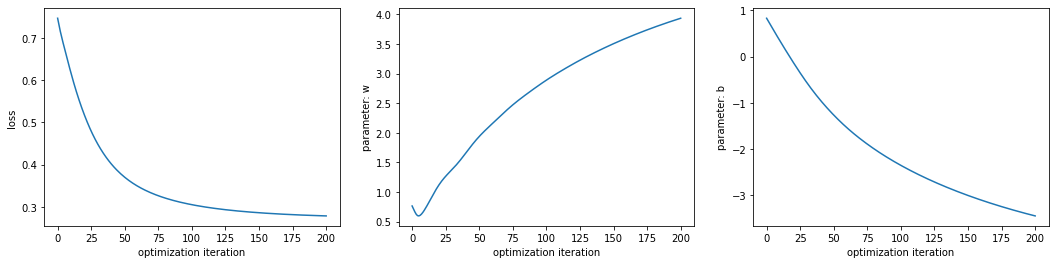

In [202]:
# Randomly initialize weights and other data
torch.manual_seed(42)
#w = torch.randn(1, requires_grad=True).reshape(1,1)
#b = torch.randn(1, requires_grad=True).reshape(1,1)
x_tensor = torch.tensor(x).float()
y_tensor = torch.tensor(y).float().reshape(N, D_out)

# Define a Perceptron class 
class Perceptron(torch.nn.Module):
    def __init__(self, input_dim):
        super(Perceptron, self).__init__()
        self.lay1 = torch.nn.Linear(input_dim, 1)
        self.act = torch.nn.Sigmoid()
    def forward(self, x, apply_sigmoid=False):
        output = self.lay1(x)
        if apply_sigmoid:
            output = self.act(output)
        return output

model = Perceptron(1)

# Define loss function to be used 
#loss_fn = torch.nn.MSELoss()
#loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.BCEWithLogitsLoss()
learning_rate = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
params = []

# Carry out gradient descent 
for i in range(200+1):

    params.append(tuple([param.item() for param in model.parameters()]))

    # Forward pass: compute predicted y
    y_pred = model.forward(x_tensor, apply_sigmoid=False)

    # Compute and store loss, and print occassionally 
    loss = loss_fn(y_pred, y_tensor)
    
    losses.append(loss.item())
    if i % 50 == 0:
        print(f"iteration {i}: loss = {loss.item():.4f}") #" w = {w[0]:.4f}, b = {b[0]:.4f}")

    # Zero all gradients before backward pass
    optimizer.zero_grad()

    # Backprop then call optimizer step to update all (relevant) model parameters
    loss.backward()
    optimizer.step()

print("w and b estimates:")
for param in model.parameters():
    print(f"   {param.item():.4f}")


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))
ax1.plot(range(0,len(losses)), losses)
ax1.set(xlabel="optimization iteration", ylabel="loss")
ax2.plot(range(0,len(params)), [parm[0] for parm in params])
ax2.set(xlabel="optimization iteration", ylabel="parameter: w")
ax3.plot(range(0,len(params)), [parm[1] for parm in params])
ax3.set(xlabel="optimization iteration", ylabel="parameter: b")

There is one remaining issue that we have not dealt with yet, and that you might be wondering about. If you recall, Deep Learning is not only about using large neural network models with many hidden layers. It's also often relies on large, voluminous sets of data, oftentimes so large that calculating the gradients becomes computationally impractical, and sometimes so large that it all can't even be fit into memory at one time. In the next notebook we'll see how this is dealt with, how this affects optimization (and the surface of the loss function), and how this can be advantageous as well. 